# Calculate Confusion Matrix

A ready-to-use script to calculate confusion matrix.

**Input**:
- Existing project annotated with both ground truth and predicted objects.
- At least one pair of corresponding ground truth and prediction class names, e.g. ("person", "person_predicted").

**Output**:
- Confusion matrix as a Python dict with counts of matched object for each combination of classes.


## Imports

In [1]:
import supervisely_lib as sly
import os
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
%matplotlib inline

## Configuration

Edit the following settings for your own case

In [2]:
# Change this field to the name of your team, where target workspace exists.
team_name = "jupyter_tutorials"

# Change this field to the of your workspace, where target project exists.
workspace_name = "metrics_tutorials"

# Change this field to the name of your target project.
project_name = "confusion_matrix_demo_project"

# Configure the following dictionary so that is will match pairs of ground truth and
# predicted object classes for which the confusion matrix will be caluclated.
classes_mapping = {
    "bike": "motorbike_pred",
    "dog": "dog_pred",
    "person": "person_pred",
}

# Minimum intersection over uinon value for which to overlapping objects will be
# considered to have matched. Increase to only take close matches into account;
# decrease to also consider less significant overlaps.
iou_threshold = 0.5

# If you are running this notebook on a Supervisely web instance, the connection
# Edit those values if you run this notebook on your own PC
# details below will be filled in from environment variables automatically.
#
# If you are running this notebook locally on your own machine, edit to fill in the
# connection details manually. You can find your access token at
# "Your name on the top right" -> "Account settings" -> "API token".
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

## Script setup

Initialize Supervisely API to remotely manage your projects

In [3]:
# Initialize API object
api = sly.Api(address, token)

## Verify input values

Test that context (team / workspace / project) exists

In [4]:
team = api.team.get_info_by_name(team_name)
if team is None:
    raise RuntimeError("Team {!r} not found".format(team_name))

workspace = api.workspace.get_info_by_name(team.id, workspace_name)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(workspace_name))
    
project = api.project.get_info_by_name(workspace.id, project_name)
if project is None:
    raise RuntimeError("Project {!r} not found".format(project_name))
    
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))
print("Project: id={}, name={}".format(project.id, project.name))

Team: id=5, name=antonc
Workspace: id=22, name=metrics
Project: id=88, name=confusion_matrix_demo_project


## Get source project meta

Project meta contains information about classes and tags.

In [5]:
meta_json = api.project.get_meta(project.id)
meta = sly.ProjectMeta.from_json(meta_json)

# check that all classes exist
project_classes_names = list(classes_mapping.keys()) + list(classes_mapping.values())

for class_name in project_classes_names:
    if not meta.obj_classes.has_key(class_name):
        raise RuntimeError("Class {!r} not found in source project {!r}".format(class_name, project.name))

## Create metric evaluator

In [6]:
confusion_matrix_evaluator = sly.ConfusionMatrixMetric(classes_mapping, iou_threshold)

## Iterate over all images, and calculate metric by annotations pairs

In [7]:
for dataset in api.dataset.get_list(project.id):
    
    # generate dataset name in destination project if it exists
    print("Processing: project = {!r}, dataset = {!r}".format(project.name, dataset.name), flush=True)
    
    images = api.image.get_list(dataset.id)
    with tqdm(total=len(images), desc="Process annotations") as progress_bar:
        for batch in sly.batched(images):
            image_ids = [image_info.id for image_info in batch]
            ann_infos = api.annotation.download_batch(dataset.id, image_ids)
            
            for ann_info in ann_infos:
                ann = sly.Annotation.from_json(ann_info.annotation, meta)
                # We are using the same annotation on the both side of the metric computation
                # (classes_mapping provides the corresponding classes that we will look for
                # in the annotation), but it is also possible to use different annotations
                # on left and right, e.g. to compare the source hand-labeled project to a
                # neural netork inference result.
                confusion_matrix_evaluator.add_pair(ann, ann)
            
            progress_bar.update(len(batch))

Processing: project = 'confusion_matrix_demo_project', dataset = 'dataset_02'


Process annotations: 100%|██████████| 2/2 [00:00<00:00, 42.69it/s]

Processing: project = 'confusion_matrix_demo_project', dataset = 'dataset_01'



Process annotations: 100%|██████████| 3/3 [00:00<00:00, 21.75it/s]


## Print results with default logger

The results are logged with the default Supervisely logger, so that the same code can be used in any custom plugin, and the log output would be nicely formatted in the task log.

In [8]:
confusion_matrix_evaluator.log_total_metrics()

{"message": "                                                                                ", "timestamp": "2019-04-24T14:14:34.537Z", "level": "info"}
{"message": "***************** Result metrics values for 0.5 IoU threshold ******************", "timestamp": "2019-04-24T14:14:34.538Z", "level": "info"}
{"message": "******************************* Confusion matrix *******************************", "timestamp": "2019-04-24T14:14:34.539Z", "level": "info"}
{"message": "                       motorbike_pred         dog_pred          person_pred       False Negatives   ", "timestamp": "2019-04-24T14:14:34.542Z", "level": "info"}
{"message": "        bike                 2                   0                   0                   1          ", "timestamp": "2019-04-24T14:14:34.544Z", "level": "info"}
{"message": "                                                                                ", "timestamp": "2019-04-24T14:14:34.545Z", "level": "info"}
{"message": "        dog            

## Print results manually

In [9]:
# Metrics for each pair of classes separately.
results = confusion_matrix_evaluator.get_metrics()
pairs_counts, false_negatives, false_positives = results

def plot_confusion_matrix(confusion_matrix, gt_classes, pred_classes, cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(gt_classes))
    plt.xticks(tick_marks, pred_classes, rotation=45)
    plt.yticks(tick_marks, gt_classes)

    color_thresh = confusion_matrix.max() / 2.
    for gt_idx, pred_idx in itertools.product(range(confusion_matrix.shape[0]),
                                              range(confusion_matrix.shape[1])):
        num_matches = confusion_matrix[gt_idx, pred_idx]
        plt.text(pred_idx, gt_idx, format(num_matches, 'd'),
                 horizontalalignment="center",
                 color="white" if num_matches > color_thresh else "black")

    plt.ylabel('True classes')
    plt.xlabel('Predicted classes')
    plt.tight_layout()

num_classes = len(classes_mapping)
conf_mat = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)

sorted_gt_names = sorted(classes_mapping.keys())
ordered_pred_names = [classes_mapping[gt_name] for gt_name in sorted_gt_names]

for gt_idx, gt_class in enumerate(sorted_gt_names):
    for pred_idx, pred_class in enumerate(ordered_pred_names):
        conf_mat[gt_idx, pred_idx] = pairs_counts[(gt_class, pred_class)]
        conf_mat[gt_idx, num_classes] = false_negatives[gt_class]
        conf_mat[num_classes, pred_idx] = false_positives[pred_class]
        
gt_classes = sorted_gt_names + ['False Positives']
pred_classes  = ordered_pred_names + ['False Negatives']

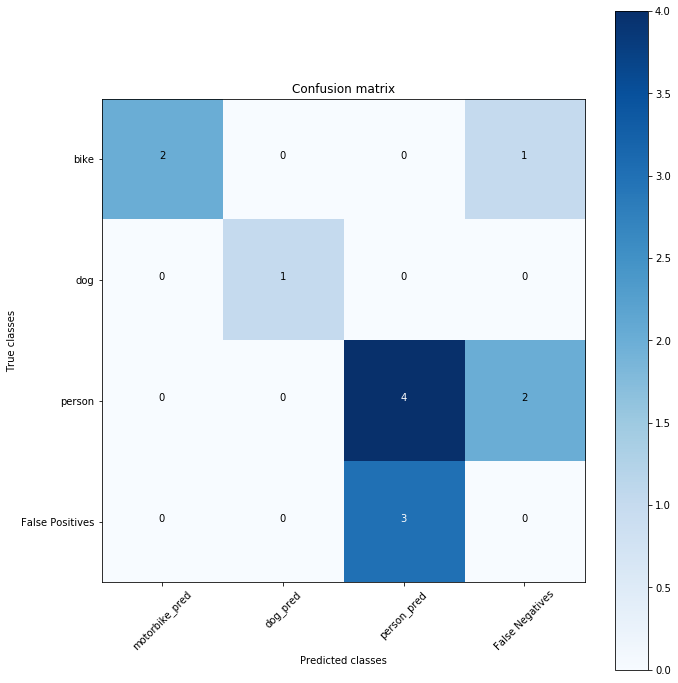

In [10]:
plot_confusion_matrix(conf_mat, gt_classes, pred_classes)

# Done!